# Introduction and Problem Statement

This project is an attempt at a kaggle competition where users are challenged to classify a dataset of tweets as to whether or not they are related to a disaster occurence or not. Twitter, which has become in modern times, a defacto sounding board for public sentiment is a rich repository of data for identifying trending current events. This dataset conists of a train and test set, which are a catalog of tweets that are either disaster related or not. It is the job of the below model to classify them as accurately as possible.

The project pipeline will flow as follows:
1. Data Load and Ingestion
2. EDA and Data Inspection
3. Data Preprocessing
4. Model 0 (Baseline Model)
5. Model 1-4 (Hyperparameter Tuning on LSTM)
5. Model 5-8 (Hyperparamater Tuning on GRU)
5. Results and Analysis
6. Discussion of Results and Conclusion
7. References

## Library Import

Importing all necesary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
import re
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU, Input, Concatenate, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score, precision_score

## Data Load and Ingestion



For the data load and ingestion process, I uploaded to a google drive and unzipped via google colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir -p data
!unzip '/content/drive/MyDrive/NLPDisasterTweets/nlp-getting-started.zip' -d data

Archive:  /content/drive/MyDrive/NLPDisasterTweets/nlp-getting-started.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


In [4]:
!ls data

sample_submission.csv  test.csv  train.csv


# EDA and Data Inspection

Frist, the below code simply inspects the features of the data, their length, and count of NaN values.

The train dataset is 7615 rows long, with 4 features (id, keyword, location, text, target). There are some significant lapses of data in the location feature, so this will be important to address.

In [5]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')


In [6]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


The below code inspects the count of characters and words across the 'text' feature. This seems to be most likely the defining feature of this dataset.

In [8]:
train_df['char_len'] = train_df['text'].str.len()
train_df['word_len'] = train_df['text'].str.split().apply(len)

train_df[['char_len', 'word_len']].describe()

,char_len,word_len
count,7613.000000,7613.000000
mean,101.037436,14.903586
std,33.781325,5.732604
min,7.000000,1.000000
25%,78.000000,11.000000
50%,107.000000,15.000000
75%,133.000000,19.000000
max,157.000000,31.000000


The plot below shows the distribution of word count across tweets classified as Disaster tweets vs those that are not. As one can see below, there is significant overlap between these two classes, which means that word count will not be a strong indicator of Disaster occurence. This is something to keep in mind when modeling is done.

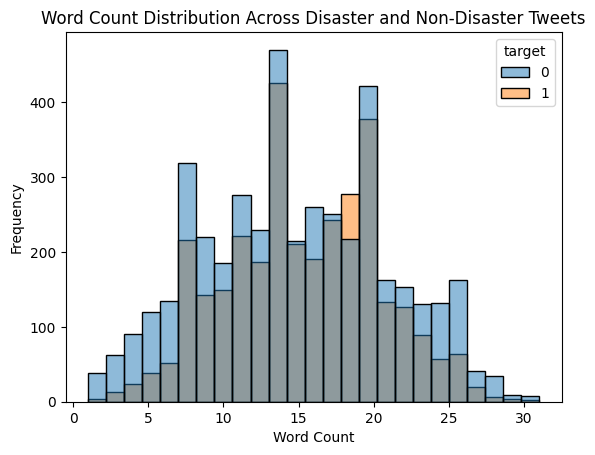

In [9]:
plt.figure()
sns.histplot(data = train_df, x = 'word_len', hue = 'target', bins = 25)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution Across Disaster and Non-Disaster Tweets')
plt.show()

The two below plots show missing values in the the features given in the dataset. The second plot shows the percentage of missing values in proportion to the total length of the dataset. As one can see there are significant missing values in location (33% missing) and a few missing values in keyword (0.8% missing).

<Figure size 400x400 with 0 Axes>

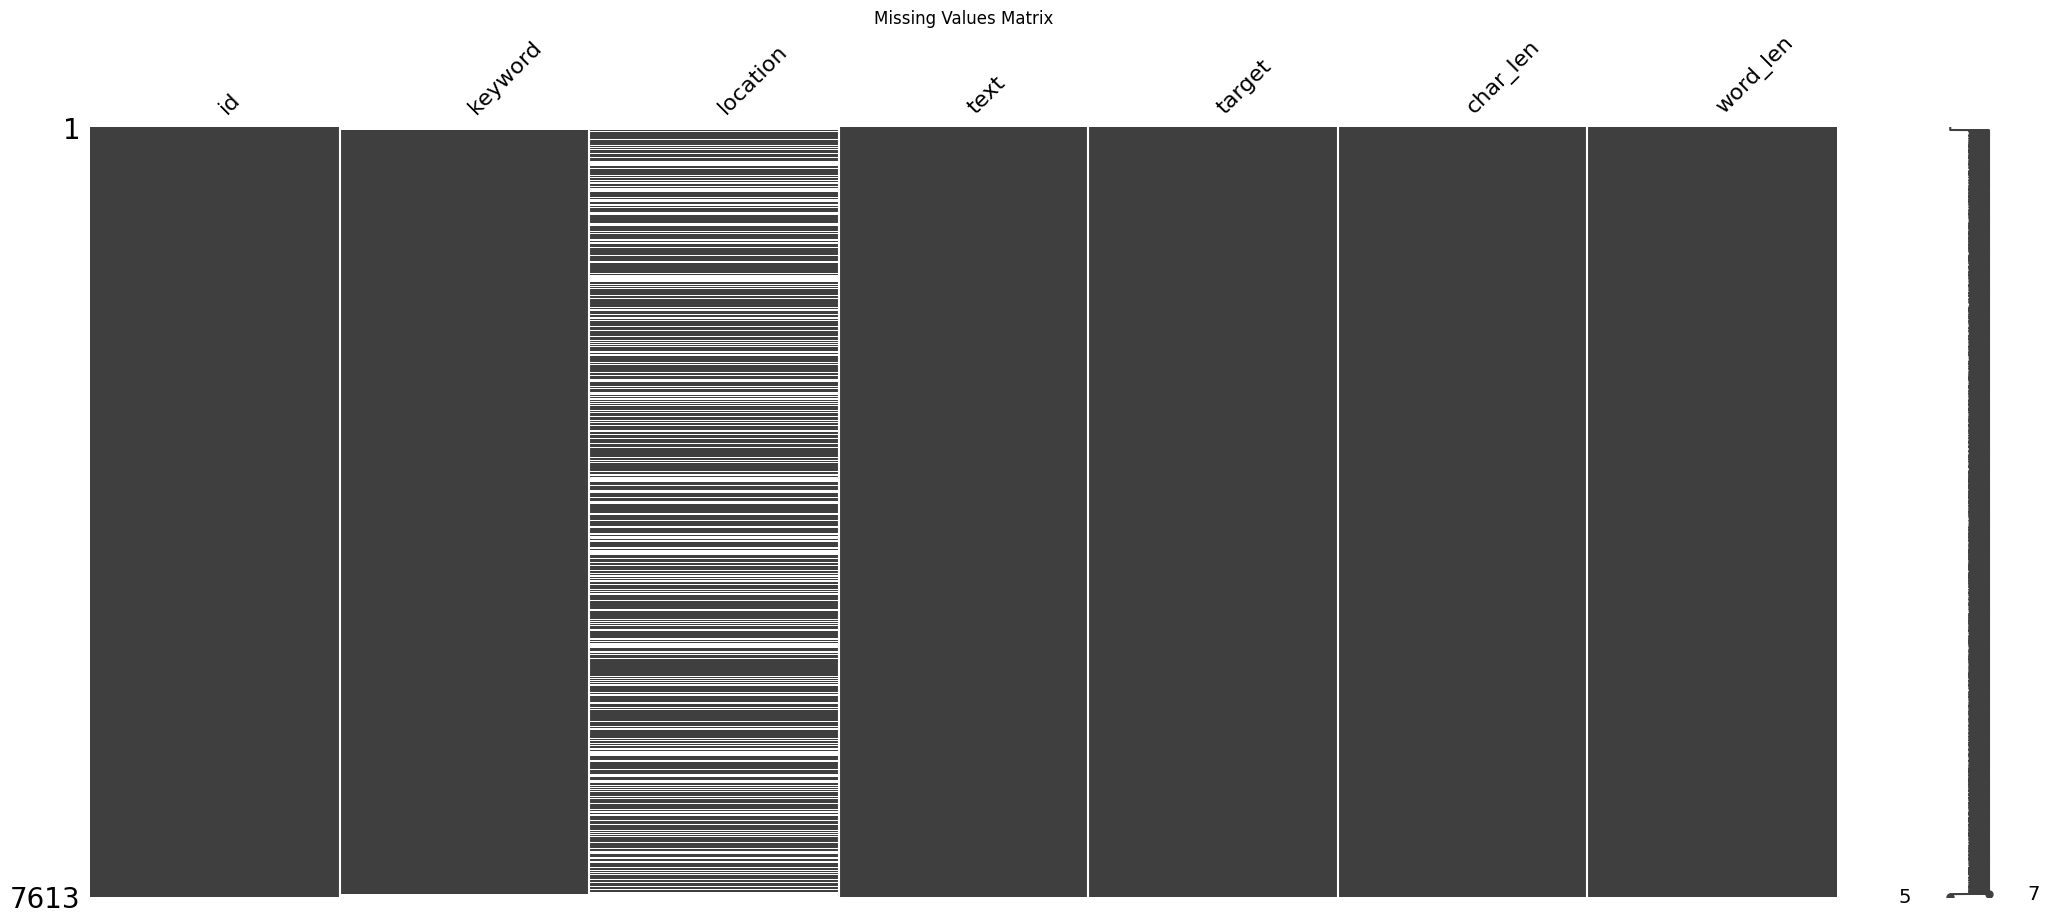

In [10]:
import missingno as msno
plt.figure(figsize = (4,4))
msno.matrix(train_df)
plt.title('Missing Values Matrix')
plt.show()

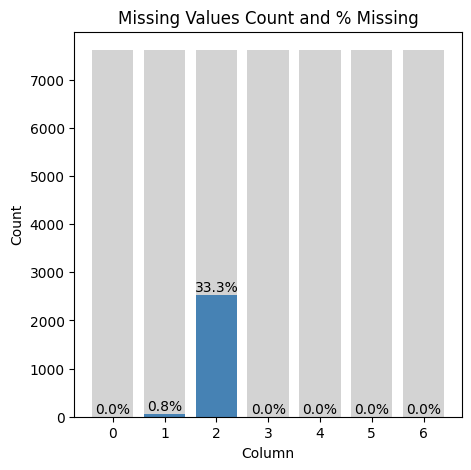

In [11]:
plt.figure(figsize=(5,5))
#sns.barplot(x = train_df.isna().mean().index, y = train_df.isna().mean().values)
na_val = train_df.isna().sum()

plt.bar(np.arange(len(na_val.index)), [len(train_df)]*len(na_val.index), color = 'lightgray', label = 'Value Count')

plt.bar(np.arange(len(na_val.index)), na_val.values, color = 'steelblue', label = 'Missing Value Count')

for i, val in enumerate(na_val.values):
  perc = val/(len(train_df))
  plt.text(i, val + (len(train_df)*0.01), f'{perc:.1%}', ha = 'center' )

plt.title('Missing Values Count and % Missing')
plt.xlabel('Column')
plt.ylabel('Count')
plt.show()

The below plot is a word cloud of the entire train dataset. It shows the most common words, with their size in the word cloud correlating with their frequency of occurence. As one can see there are some filler words, such as https, t, co, amp. This is good to know as we can filter these out in data pre-processing.

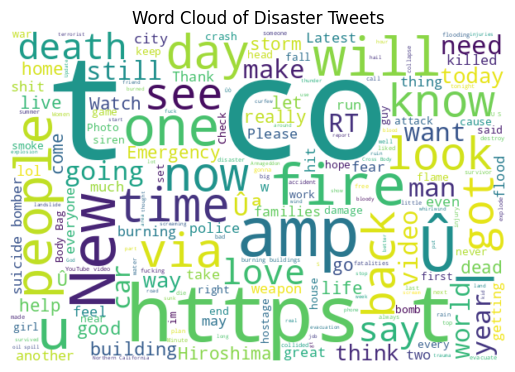

In [12]:
plt.figure
plt.imshow(WordCloud(width= 600, height = 400, background_color= 'white', stopwords =set(STOPWORDS),
                     max_words = 200).generate(' '.join(train_df['text'])), interpolation= 'bilinear')
plt.axis('off')
plt.title('Word Cloud of Disaster Tweets')
plt.show()


# Data Pre-Processing

After performing EDA, it becomes clear that the two most relavant features for prediction in this dataset are 'text' and 'keyword'. Location, while it could have been potentially useful, is filled with NaaN for 33% of its values. Additionally, location is not necesarily important to determining whether a disaster occurence has happened, it is more important in defining ***where*** the disaster occured. In this way it is not a relevant predictive feature

Therefore, this model will only incorporate 'text' and 'keyword' as predictive features on 'target'.

Now, in terms of preprocessing the data, the first step below that occurs is simply cleaning the text feature, lowercasing values in 'text', removing long spaces, and any other values that might interfere with modeling.

In [13]:
def preprocess(text):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower() #lowercasing everything
    text = re.compile(r'https?://\S+|www\.\S+').sub(' ', text) #no website references
    text = re.compile(r'<.*?>').sub(' ', text) #no html tags
    text = re.compile(r'&\w+;').sub(' ', text)
    text = re.compile(r'[^a-zA-Z@\s#]').sub(' ', text) #words + @s and #s
    text = re.compile(r'\s+').sub(' ', text).strip() #no long spaces

    return text

train_df['proc_text'] = train_df['text'].apply(preprocess)
test_df['proc_text'] = test_df['text'].apply(preprocess)

train_df['proc_keyword'] = train_df['keyword'].fillna('no_key').str.replace(' ', '_')
test_df['proc_keyword'] = test_df['keyword'].fillna('no_key').str.replace(' ', '_')

Now, splitting the data into train and validation sets, using an 80/20 split below.

In [14]:
X_train, X_val, y_train, y_val = train_test_split(train_df[['proc_text', 'proc_keyword']], train_df['target'], test_size = 0.2,
                                                  random_state = 42, stratify = train_df['target'])

X_traint = X_train['proc_text']
X_traink = X_train['proc_keyword']
X_valt = X_val['proc_text']
X_valk = X_val['proc_keyword']

#print(len(X_train), len(X_val), len(y_train), len(y_val))

One of the final steps in preprocessing that I am taking is using Keras Tokenizer to build a word index and then convert the tweets into integer sequences. After building the word index and converting the text into sequences, I am applying padding to ensure everything has the equivalent length.

This step is critical in allowing the LSTM and GRU models below to take in the data, as raw text needs to be converted into a numeric value that the models can understand.

In [15]:
token = Tokenizer(num_words = 10000, oov_token= '<OOV>')
token.fit_on_texts(X_traint)

train_t = token.texts_to_sequences(X_traint)
val_t = token.texts_to_sequences(X_valt)
test_t = token.texts_to_sequences(test_df['proc_text'])

train_p = pad_sequences(train_t, maxlen = 50, padding = 'post', truncating = 'post')
val_p = pad_sequences(val_t, maxlen = 50, padding = 'post', truncating = 'post')
test_p = pad_sequences(test_t, maxlen = 50, padding = 'post', truncating = 'post')

After tokenizing the 'proc_text' values, which are the body of the tweet, I am taking the keyword value that has been processed and label encoding it to turn each keyword into an integer. As the keywords are a single value, they dont need to be ran through the tokenizer to become sequenced. This step will suffice in converting the data to numeric values for the models below to interpret.

In [16]:
kw = LabelEncoder()
kw.fit(pd.concat([train_df['proc_keyword'], test_df['proc_keyword']], axis = 0))

train_k = kw.transform(X_traink)
val_k = kw.transform(X_valk)
test_k = kw.transform(test_df['proc_keyword'])

size = len(kw.classes_)

# Model 0: Baseline LSTM

The first step I am taking in modeling is simply defining a baseline model, Model 0, to first see an initial result before moving onto hyperparamater tuning. Seeing this initial result will help define what hyperparameters need to be tuned and what values they many need to be.

This initial model is an LSTM. Below, the code wraps the model architecture in a function, which will be called upon in training.

In terms of general architecture the model first takes the tokenized tweet and label encodded keyword values as input. After this, and embedding layer is applied to the tweet text and keyword. Then LSTM is applied. This is passed through a dense layer with 64 units and a ReLU activation, a dropout layer of 0.3, and then a final dense layer with Sigmoid activation. The ouput is a probability value (showing the likliehood of a disaster tweet or not).

This is a smiple first architecutre, establishing a baseline that can be tuned in further model runs.

In [17]:

def lstm0_func():

  input_t = Input(shape = (50,), name = 'text_in')
  input_k = Input(shape = (1,), name = 'keyword_in')

  t = Embedding(input_dim =10000, output_dim = 100, mask_zero=True)(input_t)
  t = LSTM(128, return_sequences = False)(t)
  t = Dropout(0.3)(t)

  k = Embedding(input_dim = size, output_dim = 16)(input_k)
  k = Flatten()(k)

  model = Concatenate()([t, k])
  model = Dense(64, activation = 'relu')(model)
  model = Dropout(0.3)(model)
  model = Dense(1, activation = 'sigmoid')(model)

  model = Model(inputs = [input_t, input_k], outputs = model)
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


  return model

In [18]:
lstm0 = lstm0_func()
lstm0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_in             │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 100)   │  1,000,000 │ text_in[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 50)        │          0 │ text_in[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keyword_in          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │    117,248 │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 16)     │      3,552 │ keyword_in[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 144)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      9,280 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,130,145 (4.31 MB)

 Trainable params: 1,130,145 (4.31 MB)

 Non-trainable params: 0 (0.00 B)

The first training run begins below for the baseline LSTM (lstm0). As one can see, early stoppage is being used to reduce overfitting, and conserve unecesary computational expense.

In [19]:
stopage = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

hist_lstm0 = lstm0.fit([train_p, train_k], y_train, validation_data = ([val_p, val_k], y_val), epochs = 15, batch_size = 64,
                       callbacks = [stopage], verbose = 1)

Epoch 1/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 158ms/step - accuracy: 0.6045 - loss: 0.6422 - val_accuracy: 0.8129 - val_loss: 0.4362
Epoch 2/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.8641 - loss: 0.3347 - val_accuracy: 0.8102 - val_loss: 0.4509
Epoch 3/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.9168 - loss: 0.2251 - val_accuracy: 0.8017 - val_loss: 0.5033
Epoch 4/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.9462 - loss: 0.1550 - val_accuracy: 0.7840 - val_loss: 0.7152


The below plots show the baseline models Training Loss, Validation Loss, Training Accuracy, and Validation accuracy over the epochs it was trained. This is a good first result, but this can surely be improved upon with some tuning.

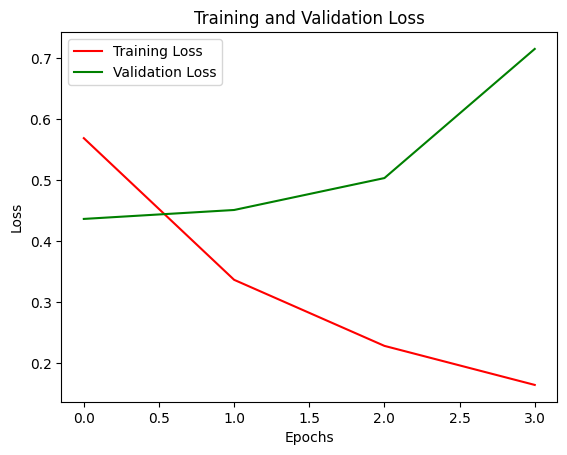

In [20]:
plt.figure()
plt.plot(hist_lstm0.history['loss'], 'r', label = 'Training Loss')
plt.plot(hist_lstm0.history['val_loss'], 'g', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

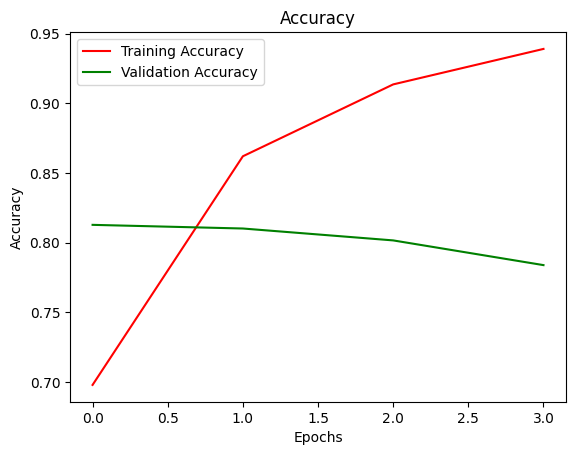

In [21]:
plt.figure()
plt.plot( hist_lstm0.history['accuracy'], 'r', label = 'Training Accuracy')
plt.plot( hist_lstm0.history['val_accuracy'], 'g', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# Model 1-4: Hyperparameter Tuning on LSTM

Now, moving on to the next set of models, which are a hyperparameter tuned version of the baseline LSTM. The model architecture below is simmilar, except the function takes three inputs (embedded dimensions, units, and dropout rate), which will be defined by tuning structure below.

In terms of general architecture the model first takes the tokenized tweet and label encodded keyword values as input. After this, and embedding layer is applied (with embedded dimensions being 64, 100, or 128) to the tweet text and keyword. Then LSTM is applied. This is passed through a dense layer with 64, 128, or 256 units (depending on the parameter in the LSTM_tune search) and a ReLU activation, a dropout layer of 0.3, and then a final dense layer with Sigmoid activation. The ouput is a probability value (showing the likliehood of a disaster tweet or not).

In [22]:
def lstm_func(emb_dim, units, dropout):
  input_t = Input(shape = (50,), name = 'text_in')
  input_k = Input(shape = (1,), name = 'keyword_in')

  t = Embedding(input_dim =10000, output_dim = emb_dim, mask_zero= True)(input_t)
  t = LSTM(units, return_sequences = False)(t)
  t = Dropout(dropout)(t)

  k = Embedding(input_dim = size, output_dim = 16)(input_k)
  k = Flatten()(k)

  model = Concatenate()([t, k])
  model = Dense(64, activation = 'relu')(model)
  model = Dropout(dropout)(model)
  model = Dense(1, activation = 'sigmoid')(model)

  model = Model(inputs = [input_t, input_k], outputs = model)
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


  return model

This hyperparameter tuning list, takes 4 variation of different parameters, that are passed through the function above when training occurs.

In [23]:
lstm_tune = [{'name': 'lstm1', 'emb_dim': 64, 'units': 64, 'dropout': 0.3},
              {'name': 'lstm2', 'emb_dim': 128, 'units': 64, 'dropout': 0.3},
              {'name': 'lstm3', 'emb_dim': 100, 'units': 128, 'dropout': 0.3},
              {'name': 'lstm4', 'emb_dim': 100, 'units': 256, 'dropout': 0.3
              }]

The below code trains each separte model (1-4), with the above parameters. When training each of these models, it takes the results, history, and model data and stores them so they can be referenced later when final model selection is done.

In [24]:
result_lstm = []
hist_lstm = {}
model_lstm = {}

stopage = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

for i in lstm_tune:
  print(i['name'])
  model = lstm_func(emb_dim = i['emb_dim'], units = i['units'], dropout = i['dropout'])

  hist = model.fit([train_p, train_k], y_train, validation_data = ([val_p, val_k], y_val), epochs = 15, batch_size = 64, callbacks = [stopage],
                       verbose = 1)

  model_lstm[i['name']] = model
  hist_lstm[i['name']] = hist

  val_loss, val_acc = model.evaluate([val_p, val_k], y_val, verbose = 0)
  epoch = len(hist.history['loss'])

  result_lstm.append([i['name'], i['emb_dim'], i['units'], i['dropout'], epoch, val_loss, val_acc])



lstm1
Epoch 1/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.6182 - loss: 0.6440 - val_accuracy: 0.8096 - val_loss: 0.4322
Epoch 2/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8581 - loss: 0.3409 - val_accuracy: 0.8234 - val_loss: 0.4255
Epoch 3/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.9210 - loss: 0.2218 - val_accuracy: 0.7991 - val_loss: 0.5062
Epoch 4/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.9465 - loss: 0.1578 - val_accuracy: 0.7938 - val_loss: 0.6207
Epoch 5/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.9616 - loss: 0.1126 - val_accuracy: 0.7735 - val_loss: 0.6828
lstm2
Epoch 1/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.6305 - loss: 0.6327 - val_accuracy: 0.8109 - val_loss: 0.4362
Epoch 2/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.8699 - loss: 0.3259 - val_accuracy: 0.8089 - val_loss: 0.4514
Epoch 3/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.9242 - loss: 0.2099 - val_acc

The below code prints the results of this modeling run and shows which of the LSTM models performed best.

In [25]:
result_lstm_df = pd.DataFrame(result_lstm, columns = ['Name', 'Emb_Dim', 'Units', 'Dropout', 'Epochs', 'Val_Loss', 'Val_Acc']).sort_values(by = 'Val_Acc', ascending = False)
result_lstm_df

,Name,Emb_Dim,Units,Dropout,Epochs,Val_Loss,Val_Acc
0,lstm1,64,64,0.3,5,0.425525,0.823375
2,lstm3,100,128,0.3,4,0.435291,0.814839
3,lstm4,100,256,0.3,5,0.455845,0.811556
1,lstm2,128,64,0.3,4,0.436200,0.810900


# Model 4-8: Hyperparameter Tuning with GRU

The next set of models utilize GRU, instead of LSTM. I have trained these models with the same set of hyperparameters that are used in the LSTM models. The architecture is also similar to that of the LSTM models.

In terms of general architecture the model first takes the tokenized tweet and label encodded keyword values as input. After this, and embedding layer is applied (with embedded dimensions being 64, 100, or 128) to the tweet text and keyword. Then GRU is applied. This is passed through a dense layer with 64, 128, or 256 units (depending on the parameter in the GRU_tune search) and a ReLU activation, a dropout layer of 0.3, and then a final dense layer with Sigmoid activation. The ouput is a probability value (showing the likliehood of a disaster tweet or not).

In [26]:
def gru_func(emb_dim, units, dropout):
  input_t = Input(shape = (50,), name = 'text_in')
  input_k = Input(shape = (1,), name = 'keyword_in')

  t = Embedding(input_dim =10000, output_dim = emb_dim, mask_zero=True)(input_t)
  t = GRU(units, return_sequences = False)(t)
  t = Dropout(dropout)(t)

  k = Embedding(input_dim = size, output_dim = 16)(input_k)
  k = Flatten()(k)

  model = Concatenate()([t, k])
  model = Dense(64, activation = 'relu')(model)
  model = Dropout(dropout)(model)
  model = Dense(1, activation = 'sigmoid')(model)

  model = Model(inputs = [input_t, input_k], outputs = model)
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


  return model

As mentioned previously, this gru_tune search contains the same paramaters as the LSTM model does. This keeps comparable consistency across the two models.

In [27]:
gru_tune = [{'name': 'gru5', 'emb_dim': 64, 'units': 64, 'dropout': 0.3},
              {'name': 'gru6', 'emb_dim': 128, 'units': 64, 'dropout': 0.3},
              {'name': 'gru7', 'emb_dim': 100, 'units': 128, 'dropout': 0.3},
              {'name': 'gru8', 'emb_dim': 100, 'units': 256, 'dropout': 0.3
              }]

This code block below functions the same as the LSTM model training. It builds 4 separate models (models 5-8), using the paramaters in the grid search above. It stores the results to be pulled upon later.

In [28]:
result_gru = []
hist_gru = {}
model_gru = {}
stopage = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

for i in gru_tune:


  print(i['name'])
  model2 = gru_func(emb_dim = i['emb_dim'], units = i['units'], dropout = i['dropout'])
  hist2 = model2.fit([train_p, train_k], y_train, validation_data = ([val_p, val_k], y_val), epochs = 15,
                     batch_size = 64, callbacks = [stopage],verbose = 1)

  model_gru[i['name']] = model2
  hist_gru[i['name']] = hist2

  val_loss, val_acc = model2.evaluate([val_p, val_k], y_val, verbose = 0)
  epoch = len(hist2.history['loss'])
  result_gru.append([i['name'], i['emb_dim'], i['units'], i['dropout'], epoch, val_loss, val_acc])


gru5
Epoch 1/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.5969 - loss: 0.6605 - val_accuracy: 0.7912 - val_loss: 0.4538
Epoch 2/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.8609 - loss: 0.3432 - val_accuracy: 0.8043 - val_loss: 0.4441
Epoch 3/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.9168 - loss: 0.2226 - val_accuracy: 0.7820 - val_loss: 0.5063
Epoch 4/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.9515 - loss: 0.1503 - val_accuracy: 0.7669 - val_loss: 0.6551
Epoch 5/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9667 - loss: 0.0965 - val_accuracy: 0.7827 - val_loss: 0.7237
gru6
Epoch 1/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.6041 - loss: 0.6558 - val_accuracy: 0.7919 - val_loss: 0.4684
Epoch 2/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.8526 - loss: 0.3596 - val_accuracy: 0.8155 - val_loss: 0.4455
Epoch 3/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.9170 - loss: 0.2173 - val_accura

In [29]:
result_gru_df = pd.DataFrame(result_gru, columns = ['Name', 'Emb_Dim', 'Units', 'Dropout', 'Epochs', 'Val_Loss', 'Val_Acc']).sort_values(by = 'Val_Acc', ascending = False)
result_gru_df

,Name,Emb_Dim,Units,Dropout,Epochs,Val_Loss,Val_Acc
1,gru6,128,64,0.3,5,0.445539,0.815496
3,gru8,100,256,0.3,4,0.436581,0.814839
2,gru7,100,128,0.3,5,0.448502,0.808273
0,gru5,64,64,0.3,5,0.444058,0.804334


# Results and Analysis

The final step in this process is to select the best model for submission in the kaggle project. First, the two results dataframes from the LSTM model and GRU model are taken and displayed below.

As one can see, the LSTM models performed slighly better as a whole, than the GRU models did. None of the models acutally cycled through the full 15 epochs and dropped early (due to early stoppage).

In [30]:
finalresults_df = pd.concat([result_lstm_df, result_gru_df], axis = 0)
finalresults_df

,Name,Emb_Dim,Units,Dropout,Epochs,Val_Loss,Val_Acc
0,lstm1,64,64,0.3,5,0.425525,0.823375
2,lstm3,100,128,0.3,4,0.435291,0.814839
3,lstm4,100,256,0.3,5,0.455845,0.811556
1,lstm2,128,64,0.3,4,0.436200,0.810900
1,gru6,128,64,0.3,5,0.445539,0.815496
3,gru8,100,256,0.3,4,0.436581,0.814839
2,gru7,100,128,0.3,5,0.448502,0.808273
0,gru5,64,64,0.3,5,0.444058,0.804334


The below two code blocks select the best model, by the highest validation accuracy value. After this is done, best_model and best_hist are stored.

In [31]:
best_model = finalresults_df.sort_values(by = 'Val_Acc', ascending = False).iloc[0]
best_model

,0
Name,lstm1
Emb_Dim,64
Units,64
Dropout,0.3
Epochs,5
Val_Loss,0.425525
Val_Acc,0.823375


In [32]:
best_name = best_model['Name']

if best_name.startswith('lstm'):
  best_model = model_lstm[best_name]
  best_hist = hist_lstm[best_name]
elif best_name.startswith('gru'):
  best_model = model_gru[best_name]
  best_hist = hist_gru[best_name]
else:
  print('Error')
print(best_name)


lstm1


Finally, viewing the results of the best model's training loss, validation loss, training accuracy, and validation accuracy across all epochs it ran.

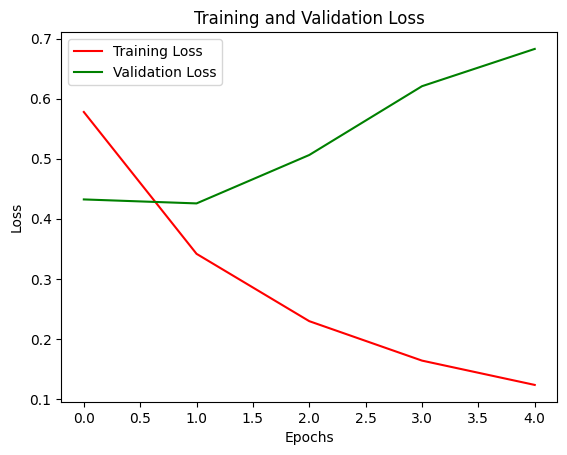

In [33]:
plt.figure()
plt.plot(best_hist.history['loss'], 'r', label = 'Training Loss')
plt.plot(best_hist.history['val_loss'], 'g', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

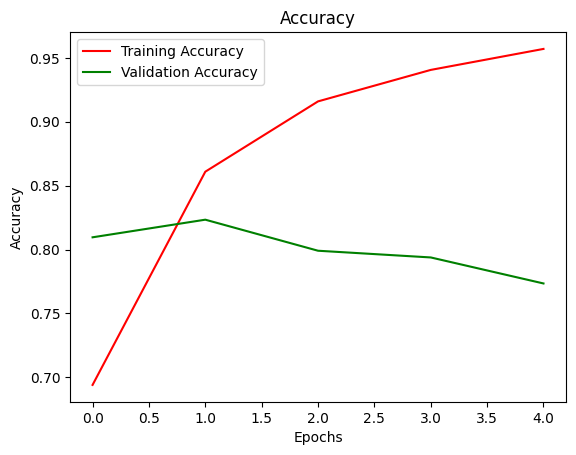

In [34]:
plt.figure()
plt.plot( best_hist.history['accuracy'], 'r', label = 'Training Accuracy')
plt.plot( best_hist.history['val_accuracy'], 'g', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

The below code prints the accuracy, precision, recall, and F1 score, alongside a classification report from the model.

In [35]:
val_pred = np.where((best_model.predict([val_p, val_k])) > 0.5, 1, 0)

print(f'Accuracy: {accuracy_score(y_val, val_pred)}')
print(f'Precision: {precision_score(y_val, val_pred)}')
print(f'Recall: {recall_score(y_val, val_pred)}')
print(f'F1 Score: {f1_score(y_val, val_pred)}')

print(classification_report(y_val, val_pred))

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Accuracy: 0.8233749179251477
Precision: 0.8456014362657092
Recall: 0.7201834862385321
F1 Score: 0.7778695293146161
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       869
           1       0.85      0.72      0.78       654

    accuracy                           0.82      1523
   macro avg       0.83      0.81      0.82      1523
weighted avg       0.83      0.82      0.82      1523



# Discussion of Results and Conclusion

This project demonstrated that using the results of pre-processed tweet text alongside keyword values, inputted into a neural network architecture, allowed for a strong disaster tweet prediction classification model.

The baseline LSTM model was able achieve a validation accuracy of ~0.80, showing that the Baseline LSTM model was valid. There were signs of overfitting in this run, when the validation accuracy platued after a few epochs.

Overall though, one can see that the hyper-parameter tuning of both LSTM and GRU helped increase overall model efficacy and validity. The specific model that performed best was lstm1, which provided a 0.82  validation accuracy. This was a positive submission result for the kaggle competition. In this case, for this dataset and specific architecture, LSTM performed better than GRU.

One improvement that could be made would be expanding the hyperparameter tuning to potentially 5 or 6 more values. This would increase the overall amount of runs needed for these models, but would allow for an increased likliehood of better results. Additionally, the use of bidirectional LSTMs could help improve modelin results, so this will be taken into account in future projects.

## Submission File Generation

In [36]:
test_pred = np.where((best_model.predict([test_p, test_k])) > 0.5, 1, 0).astype(int).flatten()
submission = pd.DataFrame({'id': test_df['id'], 'target': test_pred})
submission.to_csv('submission.csv', index = False)
submission.head()

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [37]:
submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.341404
std,3146.427221,0.474253
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [38]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# References

[1] Addison Howard, devrishi, Phil Culliton, and Yufeng Guo. Natural Language Processing with Disaster Tweets. https://kaggle.com/competitions/nlp-getting-started, 2019. Kaggle.

[2] GeeksforGeeks. (2025, July 11). Tokenization in NLP. GeeksforGeeks. https://www.geeksforgeeks.org/nlp/nlp-how-tokenizing-text-sentence-words-works/

[3] OpenAI. (2025). ChatGPT (version GPT-5) [Large language model]. OpenAI. (Used for error trace debugging and function usage examples.)

[4] Google DeepMind. (2025). Gemini [Large language model]. Google DeepMind. (Used for error trace debugging and function usage examples.)

[5] GeeksforGeeks. (2025, October 13). Gated Recurrent Unit Networks. GeeksforGeeks. https://www.geeksforgeeks.org/machine-learning/gated-recurrent-unit-networks/

[6] S. Hans. (2021). LSTM Networks | A Detailed Explanation. Towards Data Science. https://towardsdatascience.com/lstm-networks-a-detailed-explanation-8fae6aefc7f9/